# マルコフ連鎖モンテカルロ法

ベクトルや行列を太文字表記していないので要注意

In [14]:
# 必要なライブラリをインポート
from tqdm import trange
import numpy as np
import scipy.linalg as la
import scipy.stats as st
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

## マルコフ連鎖と不変分布

### マルコフ連鎖の概要
確率変数の系列$\{X_t\}_{t=0}^{\infty}$に対して，$\{X_s\}_{s=0}^{t-1}$の実現値$\{x_s\}_{s=0}^{t-1}$が与えられた下で$X_t$が部分集合$A \subseteq \chi$内に値をとる条件付き確率が以下のように表現されるとき，$\{X_t\}_{t=0}^{\infty}$は**マルコフ連鎖**であるという．
$$
    Pr\{ X_t \in A| X_0=x_0, \dotsc , X_{t-1}=x_{t=1} \} = 
    Pr\{ X_t \in A| X_{t-1}=x_{t-1} \} \tag{1-1}
$$
> 要は，確率変数$X_t$の条件付き確率分布は直近の確率変数の実現値$x_{t-1}$にのみ依存している．

マルコフ連鎖における重要な概念
- 斉時性: (1-1)式の条件付き確率が時点$t$に依存しないこと
- 規約性: 確率分布$f$で実現しうる$\chi$内のいかなる場所にもマルコフ連鎖が到達可能であること
- 周期性: 一定の時間を経過しないとマルコフ連鎖が再び訪れることができない場所が$\chi$内に存在すること
- 再帰性: 確率分布$f$で実現しうる$\chi$内のいかなる場所にもマルコフ連鎖が有限時間内に必ず訪れること

$X_t$の$\{x_s\}_{s=0}^{t-1}$が与えられた下での条件付き確率分布は以下の通り．
$$
    f_t(x_t|x_0, \dotsc, x_{t-1}) = f(x_t|t_{t-1}) \tag{1-2}
$$
マルコフ連鎖が斉時的であるとき，(1-2)式の右辺の関数形は時点$t$に依存せず，$\{X_s\}_{s=0}^t$のどう次確率分布は以下のように与えられる．
$$
    f(x_0, \dotsc, x_t) = 
    f_0(x_0) \prod_{s=1}^t f(x_s|x_{s-1}) \tag{1-3}
$$
この$f(x_t|x_{t-1})$をマルコフ連鎖の**遷移核**と呼ぶ．

### マルコフ連鎖の不変分布
以下を満たす$\bar{f}$をマルコフ連鎖の**不変分布**または**定常分布**という．
$$
    \bar{f}(\tilde{x}) = 
    \int_{\chi} \bar{f}(x)K(x, \tilde{x})dx, 
    あるいは \
    \bar{f} = \bar{f} \circ K, \tag{1-4}
$$
ここで$K$はマルコフ連鎖の遷移核を表す．


### マルコフ連鎖からの乱数系列の生成
斉時的なマルコフ連鎖は$f_0$と$K$にのみ依存するという簡単な構造をしており，$f_0$と$K$からの乱数生成が可能であれば，マルコフ連鎖からの乱数生成を以下の手順で行うことができる．
1. $t=1$として$\tilde{x}_0 \gets f_0(x_0)$．
2. $\tilde{x}_t \gets K(\tilde{x}_{t-1}, x_t)$．
3. $t$を$1$増やして手順2に戻る

マルコフ連鎖が$\bar{f}$に収束したと判断されるまで乱数$\{\tilde{x_t}\}_{t=0}^{t^*}$を生成し続けることを**検査稼働期間**（バーンイン）と呼ぶ．そして，$\bar{f}$に収束したと判断した回以降のマルコフ連鎖から生成した$\{\tilde{x}_t\}_{t={t^*}+1}^{{t^*}+T}$は$\bar{f}$からのモンテカルロ標本として利用可能である．

不変分布への収束後のサンプリングは大きく分けて(i)多重連鎖法，(ii)単一連鎖法 の2通り

(i)多重連鎖法の手順
1. $\tilde{x}_0 \gets f_0(x_0)$．
2. マルコフ連鎖から分布が収束するまで乱数を生成する．
3. 最後の$\tilde{x}_t$を保存し，手順1に戻る．

(ii)単一連鎖法の手順
1. $\bar{f}$の取りうる領域から$\tilde{x}_0$を選ぶ．
2. マルコフ連鎖から分布が収束するまで乱数を生成する．
3. 必要な数の$\tilde{x}_t$を続けてマルコフ連鎖から生成する．

## メトロポリス-ヘイスティングズ・アルゴリズム（M-Hアルゴリズム）
マルコフ連鎖サンプリング法のために事後分布を不変分布に持つマルコフ連鎖を構築する方法の1つ．

$\theta$を確率変数，$f(\theta)$を$\theta$の乱数を生成したい目標分布とし，$f$において$\theta$の取りうる値の集合$\Theta \in \{ \theta: f(\theta)>0 \}$を考える．

以下の仮定をおく．
- $f$から直接$\theta$の乱数を生成できないが，代わりにマルコフ連鎖の遷移核$q(\varphi, \theta)$からは乱数を容易に生成できる
- 遷移核$q$は斉時的である
- 任意のペア$(\varphi, \theta) \in \Theta \times \theta$に対して，$q(\varphi, \theta)>0$

このとき，$f$と$q$をうまく組み合わせて$f$に収束するマルコフ連鎖を作るテクニックを**M-Hアルゴリズム**と呼ぶ．ベイズ統計学への応用という意味では，**目標分布$f$の基準か定数が未知であっても問題なく適用できる**点で極めて有用．

M-Hアルゴリズムの手順
1. $t=1$として初期値$\theta^{(0)}$を設定する．
2. $\theta^(t)$の候補$\tilde{\theta}$をマルコフ連鎖から生成する．
$$
    \tilde{\theta} \gets q(\theta^{(t-1)}, \theta).
$$
3. $\tilde{\theta}$の採択確率を以下の計算式で計算する．
$$
    \alpha(\theta^{(t-1)}, \tilde{\theta}) = 
    \min \bigg\{ 
        \frac{f(\tilde{\theta})q(\tilde{\theta}, \theta^{(t-1)})}
            {f(\theta^{(t-1)})q(\theta^{(t-1)}, \tilde{\theta})}
        , 1 \bigg\}. \tag{2-1}
$$
4. \theta^{(t)}を以下のルールに従い更新する．
$$
    \tilde{u} \gets U(0, 1), \ 
    \theta^{(t)} = 
        \begin{cases}
            \tilde{\theta}, & (\tilde{u} \leq \alpha(\theta^{(t-1)}, \tilde{\theta})), \\
            \theta^{(t-1)}, & (\tilde{u} > \alpha (\theta^{(t-1)}, \tilde{\theta})).
        \end{cases}
$$
5. $t$を$1$つ増やして手順2に戻る．

M-Hアルゴリズムは$q$の選択に応じて幾つかに分類され，以下の手法などがある．
1. ランダムウォーク連鎖
2. 独立連鎖
3. ハミルトニアン・モンテカルロ（HMC）法

### ランダムウォーク連鎖
遷移核$q$として，以下のランダムウォーク過程を使用するM-Hアルゴリズム．
$$
    \theta = \varphi + \epsilon, \ 
    E[\epsilon] = 0, \ 
    Var[\epsilon] = \Sigma, 
    \tag{2-2}
$$

ランダムウォーク連鎖の手順
1. $t=1$として初期値$\theta^{(0)}$を設定する．
2. $\theta{(t)}$の候補$\tilde{\theta}$をランダムウォーク連鎖(2-2)から生成する．
3. $\tilde{\theta}$の採択確率を以下の式で計算する．
$$
    \alpha(\theta^{t-1}, \tilde{\theta}) = 
    \min \bigg\{ \frac{f(\theta)}{f(\theta^{t-1})}, 1 \bigg\}. 
    \tag{2-3}
$$
4. $\theta^{(t)}$を以下のルールに従い更新する．
$$
    \tilde{u} \gets U(0, 1), \ 
    \theta^{(t)} = 
        \begin{cases}
            \tilde{\theta}, & (\tilde{u} \leq \alpha(\theta^{(t-1)}, \tilde{\theta})), \\
            \theta^{(t-1)}, & (\tilde{u} > \alpha (\theta^{(t-1)}, \tilde{\theta})).
        \end{cases}
$$
5. $t$を$1$つ増やして手順2に戻る．

### 独立連鎖
遷移核$q$から生成される$\theta^{(t)}$を$\theta^{(t-1)}$と独立に生成するM-Hアルゴリズムの派生形．

独立連鎖の手順
1. $t=1$として初期値$\theta^{(0)}$を設定する．
2. $\theta^{(t)}$の候補$\tilde{\theta}$を提案分布$g(\theta)$から生成する．
$$
    \tilde{\theta} \gets g(\theta).
$$
3. $\tilde{\theta}$の採択確率を以下の式で計算する．
$$
    \alpha(\theta^{(t-1)}, \tilde{\theta}) = 
    \min \bigg\{ 
        \frac{f(\tilde{\theta})g(\theta^{(t-1)})}
        {f(\theta^{(t-1)})g(\tilde{\theta})}
        , 1
    \bigg\}. 
    \tag{2-4}
$$
4. $\theta^{(t)}$を以下のルールに従い更新する．
$$
    \tilde{u} \gets U(0, 1), \ 
    \theta^{(t)} = 
        \begin{cases}
            \tilde{\theta}, & (\tilde{u} \leq \alpha(\theta^{(t-1)}, \tilde{\theta})), \\
            \theta^{(t-1)}, & (\tilde{u} > \alpha (\theta^{(t-1)}, \tilde{\theta})).
        \end{cases}
$$
5. $t$を$1$つ増やして手順2に戻る．


### ハミルトニアン・モンテカルロ（HMC）法
$\theta$と同じ次元の$\zeta$という補助的確率変数の確率密度関数を$g(\zeta)$とし，この$(\theta, \zeta)$に対してマルコフ連鎖$q((\theta, \zeta), (\tilde{\theta}, \tilde{\zeta}))$を考える．

HMC法の手順
1. $t=1$として初期値$\theta^{(0)}$を設定する．
2. $\zeta_0 \gets N_i(0, \Sigma)$.
3. $j=0$として$\zeta \gets \zeta_0. \ \theta \gets \theta^{(t-1)}.$
4. 以下の通りにデータを生成する
$$
    \zeta^* \gets \zeta + \frac{\epsilon}{2} \nabla_{\theta}\log f(\theta), \\ 
    \tilde{\theta} \gets \theta + \epsilon \Sigma^{-1} \zeta^*, \\ 
    \tilde{\zeta} \gets \zeta^* + \frac{\epsilon}{2} \nabla_{\theta}\log f(\theta).
$$
5. $j$を$1$つ増やし，$j<L$ならば$\zeta \gets \tilde{\zeta}, \ \theta \gets \tilde{\theta}$として，手順4に戻る．
6. $\tilde{\theta}$の採択確率を以下の式で計算する．
$$
    \alpha(\theta^{t-1}, \tilde{\theta}) = 
    \min \Bigg\{ 
        \frac{\exp \Big[ \log f(\tilde{\theta}) - 
                \frac{1}{2} \tilde{\zeta}^T \Sigma^{-1} \tilde{\zeta} \Big]}
            {\exp \Big[ \log f(\theta^{(t-1)}) 
                \frac{1}{2} \zeta_0^T \Sigma^{-1} \zeta_0 \Big]}
        , 1
    \Bigg\}.
$$
7. $\theta^{(t)}$を以下のルールに従い更新する．
$$
    \tilde{u} \gets U(0, 1), \ 
    \theta^{(t)} = 
        \begin{cases}
            \tilde{\theta}, & (\tilde{u} \leq \alpha(\theta^{(t-1)}, \tilde{\theta})), \\
            \theta^{(t-1)}, & (\tilde{u} > \alpha (\theta^{(t-1)}, \tilde{\theta})).
        \end{cases}
$$
8. $t$を$1$つ増やして手順2に戻る．

## ギブズ・サンプラー
マルコフ連鎖サンプリング法のために事後分布を不変分布に持つマルコフ連鎖を構築する方法の1つ．

### 2変数のギブス・サンプラー
簡単化のため，2変数の場合を考える．<br>
2変数の同時確率分布$f(\theta_1, \theta_2)$から$(\theta_1, \theta_2)$の乱数を同時に生成することはできないが，条件付き確率分布$f(\theta_1|\theta_2), \ f(\theta_2|\theta_1)$からは，それぞれ$\theta_1$と$\theta_2$を生成することができると仮定する．

このとき2変数の同時確率分布に対するギブス・サンプラーは以下のように定義される．
1. $\theta_1^{(t)} \gets f(\theta_1|\theta_2^{(t-1)})$.
2. $\theta_2^{(t)} \gets f(\theta_2|\theta_1^{(t)})$.

このギブス・サンプラーの遷移核は以下の通り．
$$
    K(\theta^{(t-1)}, \theta^{(t)}) = 
    f(\theta_2^{(t)}|\theta_1^{(t)})f(\theta_1^{(t)}|\theta_2^{(t-1)}), 
    \tag{3-1}
$$

この遷移核$K$は不変分布が$f(\theta_1, \theta_2)$であることが知られている．


### 一般的なギブス・サンプラー

さらにギブス・サンプラーを一般的な$k$個の確率変数の同時確率分布の場合へ拡張する．2変数の場合と同様に各$\theta_j(j=1, \dotsc, k)$の条件付き確率分布
$$
    f(\theta_j|\theta_1, \dotsc, \theta_{j-1}, \theta_{j+1}, \dotsc, \theta_k)
$$
から$\theta_j$の乱数を容易に生成できると仮定すると，ギブス・サンプラーは以下のように与えられる．
- 手順1. $\theta_1^{(t)} \gets f(\theta_1|\theta_2^{(t-1)}, \dotsc, \theta_k^{t-1})$
- 手順2. $\theta_2^{(t)} \gets f(\theta_2|\theta_1^{(t-1)}, \theta_3^{(t-1)}, \dotsc, \theta_k^{(t-1)})$

...

- 手順k. $\theta_k^{(t)} \gets f(\theta_k|\theta_1^{(t)}, \dotsc, \theta_{k-1}^{(t)})$

理論上は$k$がどれだけ大きくなってもギブス・サンプラーを使うことは可能だが，現実的には$\theta$の次元
が高くなると，計算時間や収束スピードに問題があることが知られている．

そのため，$\theta$を$\theta=[\theta_1; \cdots \theta_m](1<m<k)$のように$m$個の確率分布のブロックに分割したときに，全ての$\theta_i(i=1, \dotsc, m)$の完全条件付き確率分布$f(\theta_i|\theta_{-i})$から$\theta_i$の乱数を容易に生成できるならば，ブロック$\theta_i$ごとにギブス・サンプラーを使うことで，計算時間の短縮や収束スピードの向上が図れる．


### 一般的なマルコフ連鎖サンプリング法の枠組み
$\theta$をいくつかのブロック$\theta_i(i=1, \cdots, m)$に分け，各ブロック$\theta_i$に対してM-Hアルゴリズムを適用して乱数生成を行う．

必ずしも全ての$f(\theta_i|\theta_{-i})$から乱数生成が容易に行えるとは限らないので，乱数生成の難しい$(\theta_i|\theta_{-i})$の代わりに別の分布$g(\theta_i|\theta_{-i})$から$\theta_i$の乱数を生成しM-Hアルゴリズムを適用する．

これをギブス内メトロポリス法と呼び，手順は以下の通り．
1. $t=1$として初期値$\theta^{(0)}$を設定する．
2. $i=1$とする．
3. $\tilde{\theta}_i \gets g(\theta_i|\theta_1^{(1)}, \dotsc, \theta_{i-1}^{(t)}, \theta_{i+1}^{(t-1)}, \dotsc, \theta_m^{(t-1)})$
4. $\tilde{\theta}_i$の採択確率を以下の式で計算する．
$$
    \alpha_i = 
    \min \Bigg\{ 
        \frac{f(\tilde{\theta}_i|\theta_1^{(1)}, \dotsc, \theta_{i-1}^{(t)}, \theta_{i+1}^{(t-1)}, \dotsc, \theta_m^{(t-1)})}
            {g(\tilde{\theta}_i|\theta_1^{(1)}, \dotsc, \theta_{i-1}^{(t)}, \theta_{i+1}^{(t-1)}, \dotsc, \theta_m^{(t-1)})}
        \bigg/
        \frac{f(\theta_i^{(t-1)}|\theta_1^{(1)}, \dotsc, \theta_{i-1}^{(t)}, \theta_{i+1}^{(t-1)}, \dotsc, \theta_m^{(t-1)})}
            {g(\theta_i^{(t-1)}\theta_1^{(1)}, \dotsc, \theta_{i-1}^{(t)}, \theta_{i+1}^{(t-1)}, \dotsc, \theta_m^{(t-1)})}
        , 1
    \Bigg\}
$$
5. $\theta^{(t)}$を以下のルールに従い更新する．
$$
    \tilde{u} \gets U(0, 1), \ 
    \theta^{(t)} = 
        \begin{cases}
            \tilde{\theta}, & (\tilde{u} \leq \alpha(\theta^{(t-1)}, \tilde{\theta})), \\
            \theta^{(t-1)}, & (\tilde{u} > \alpha (\theta^{(t-1)}, \tilde{\theta})).
        \end{cases}
$$
6. $t$を$1$つ増やして手順2に戻る．

100%|██████████| 22000/22000 [00:00<00:00, 32776.00it/s]


,平均,中央値,標準偏差,近似誤差,信用区間（下限）,信用区間（上限）,HPDI（下限）,HPDI（上限）,$\hat$
平均 $\mu$,0.937165,0.937481,0.266427,0.000908,0.411516,1.460200,0.891277,0.922336,0.997842
分散 $\sigma^2$,3.774353,3.683861,0.743120,0.002534,2.587482,5.497149,3.553438,3.637197,0.999388


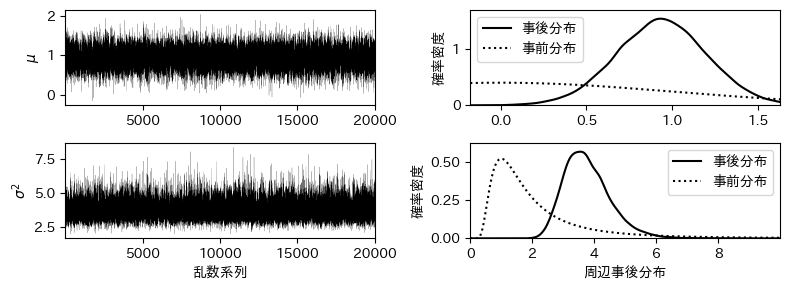

In [13]:
# 6.1: 正規分布の乱数を事後分布から生成するギブス・サンプラー
def gibbs_gaussian(data, iterations, mu0, tau0, nu0, lam0):
    n = data.size
    sum_data = data.sum()
    mean_data = sum_data / n
    variance_data = data.var()
    inv_tau02 = 1.0 / tau0**2
    mu0_tau02 = mu0 * inv_tau02
    a = 0.5 * (n+nu0)
    c = n * variance_data + lam0
    sigma2 = variance_data
    runs = np.empty((iterations, 2))
    for idx in trange(iterations):
        variance_mu = 1.0 / (n/sigma2 + inv_tau02)
        mean_mu = variance_mu * (sum_data/sigma2 + mu0_tau02)
        mu = st.norm.rvs(loc=mean_mu, scale=np.sqrt(variance_mu))
        b = 0.5 * (n*(mu-mean_data)**2 + c)
        sigma2 = st.invgamma.rvs(a, scale=b)
        runs[idx, 0] = mu
        runs[idx, 1] = sigma2
    return runs

# モンテカルロ標本からの事後統計量の計算
def mcmc_stats(runs, burnin, prob, batch):
    traces = runs[burnin:, :]
    n = traces.shape[0] // batch
    k = traces.shape[1]
    alpha = 100 * (1.0-prob)
    post_mean = np.mean(traces, axis=0)
    post_median = np.median(traces, axis=0)
    post_sd = np.std(traces, axis=0)
    mc_err = [az.mcse(traces[:, i].reshape((n, batch), order='F')).item(0)  
              for i in range(k)]
    ci_lower = np.percentile(traces, 0.5*alpha, axis=0)
    ci_upper = np.percentile(traces, 100-0.5*alpha, axis=0)
    hpdi = pm.hdi(traces, 1.0-prob)
    rhat = [az.rhat(traces[:, i].reshape((n, batch), order='F')).item(0) 
            for i in range(k)]
    stats = np.vstack((post_mean, 
                       post_median, 
                       post_sd, 
                       mc_err, 
                       ci_lower, 
                       ci_upper, 
                       hpdi.T, 
                       rhat)).T
    stats_string = ['平均', 
                    '中央値', 
                    '標準偏差', 
                    '近似誤差', 
                    '信用区間（下限）', 
                    '信用区間（上限）', 
                    'HPDI（下限）', 
                    'HPDI（上限）', 
                    '$\\hat$']
    param_string = ['平均 $\\mu$', '分散 $\\sigma^2$']
    return pd.DataFrame(stats, index=param_string, columns=stats_string)

# 正規分布からのデータ生成
mu = 1.0
sigma = 2.0
n = 50
np.random.seed(99)
data = st.norm.rvs(loc=mu, scale=sigma, size=n)

# ギブス・サンプラーの実行
mu0 = 0.0
tau0 = 1.0
nu0 = 5.0
lam0 = 7.0
prob = 0.95
burnin = 2000
samplesize = 20000
iterations = burnin + samplesize
np.random.seed(123)
runs = gibbs_gaussian(data, iterations, mu0, tau0, nu0, lam0)

# 事後統計量の計算
batch = 4
results = mcmc_stats(runs, burnin, prob, batch)
display(results)

# 事後分布のグラフの作成
fig, ax = plt.subplots(2, 2, num=1, figsize=(8, 3), facecolor='w')
labels = ['$\\mu$', '$\\sigma^2$']
for idx in range(2):
    mc_trace = runs[burnin:, idx]
    if idx==0:
        x_min = mc_trace.min() - 0.2*np.abs(mc_trace.min())
        x_max = mc_trace.max() - 0.2*np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.norm.pdf(x, loc=mu0, scale=tau0)
    else:
        x_min = 0.0
        x_max = mc_trace.max() + 0.2*np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.invgamma.pdf(x, 0.5*nu0, scale=0.5*lam0)
        ax[idx, 0].set_xlabel('乱数系列')
        ax[idx, 1].set_xlabel('周辺事後分布')
    posterior = st.gaussian_kde(mc_trace).evaluate(x)
    ax[idx, 0].plot(mc_trace, 'k-', linewidth=0.1)
    ax[idx, 0].set_xlim(1, samplesize)
    ax[idx, 0].set_ylabel(labels[idx])
    ax[idx, 1].plot(x, posterior, 'k-', label='事後分布')
    ax[idx, 1].plot(x, prior, 'k:', label='事前分布')
    ax[idx, 1].set_xlim(x_min, x_max)
    ax[idx, 1].set_ylim(0, 1.1*posterior.max())
    ax[idx, 1].set_ylabel('確率密度')
    ax[idx, 1].legend(loc='best')
plt.tight_layout()
plt.show()

100%|██████████| 22000/22000 [00:01<00:00, 15620.97it/s]


,平均,中央値,標準偏差,近似誤差,信用区間（下限）,信用区間（上限）,HPDI（下限）,HPDI（上限）,$\hat$
$\beta_1$,0.974509,0.974639,0.110833,0.000378,0.753473,1.192400,0.759947,1.196738,1.003617
$\beta_2$,2.021954,2.022413,0.111733,0.000381,1.803747,2.241445,1.804255,2.241696,0.997708
$\beta_3$,-0.868165,-0.868123,0.112170,0.000382,-1.089156,-0.648552,-1.090593,-0.650578,1.005980
$\sigma^2$,0.587697,0.571813,0.120506,0.000411,0.397683,0.869757,0.374148,0.827744,1.018295


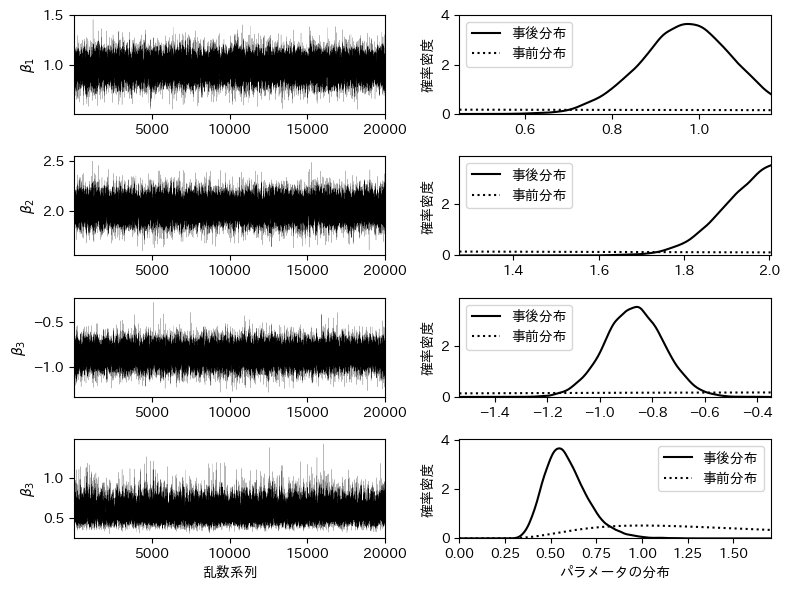

In [18]:
# 回帰モデルの乱数を事後分布から生成するギブス・サンプラー
def gibbs_regression(y, X, iterations, b0, A0, nu0, lam0):
    n, k = X.shape
    XX = X.T.dot(X)
    Xy = X.T.dot(y)
    b_ols = la.solve(XX, Xy)
    rss = np.square(y - X.dot(b_ols)).sum()
    lam_hat = rss + lam0
    nu_star = 0.5 * (n+nu0)
    A0b0 = A0.dot(b0)
    sigma2 = rss / (n-k)
    runs = np.empty((iterations, k+1))
    for idx in trange(iterations):
        cov_b = la.inv(XX / sigma2 + A0)
        mean_b = cov_b.dot(Xy / sigma2 + A0b0)
        b = st.multivariate_normal.rvs(mean=mean_b, cov=cov_b)
        diff = b - b_ols
        lam_star = 0.5 * (diff.T.dot(XX).dot(diff)+lam_hat)
        sigma2 = st.invgamma.rvs(nu_star, scale=lam_star)
        runs[idx, :-1] = b
        runs[idx, -1] = sigma2
    return runs

# モンテカルロ標本からの事後統計量の計算
def mcmc_stats(runs, burnin, prob, batch):
    traces = runs[burnin:, :]
    n = traces.shape[0] // batch
    k = traces.shape[1]
    alpha = 100 * (1.0-prob)
    post_mean = np.mean(traces, axis=0)
    post_median = np.median(traces, axis=0)
    post_sd = np.std(traces, axis=0)
    mc_err = [az.mcse(traces[:, i].reshape((n, batch), order='F')).item(0) 
              for i in range(k)]
    ci_lower = np.percentile(traces, 0.5*alpha, axis=0)
    ci_upper = np.percentile(traces, 100 - 0.5*alpha, axis=0)
    hpdi = az.hdi(traces, prob)
    rhat = [az.rhat(traces[:, i].reshape((n, batch), order='F')).item(0) 
            for i in range(k)]
    stats = np.vstack((post_mean, 
                       post_median, 
                       post_sd, 
                       mc_err, 
                       ci_lower, 
                       ci_upper, 
                       hpdi.T, 
                       rhat)).T
    stats_string = ['平均', 
                    '中央値', 
                    '標準偏差', 
                    '近似誤差', 
                    '信用区間（下限）', 
                    '信用区間（上限）', 
                    'HPDI（下限）', 
                    'HPDI（上限）', 
                    '$\\hat$']
    param_string = ['$\\beta_{0:<d}$'.format(i+1) for i in range(k-1)]
    param_string.append('$\\sigma^2$')
    return pd.DataFrame(stats, index=param_string, columns=stats_string)

# 回帰モデルからのデータの生成
n = 50
np.random.seed(99)
u = st.norm.rvs(scale=0.7, size=n)
x1 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
x2 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
y = 1.0 + 2.0*x1 -x2 + u
X = np.stack((np.ones(n), x1, x2), axis=1)

# ギブス・サンプラーの実行
k = X.shape[1]
b0 = np.zeros(k)
A0 = 0.2 * np.eye(k)
nu0 = 5.0
lam0 = 7.0
sd0 = np.sqrt(np.diag(la.inv(A0)))
prob = 0.95
burnin = 2000
samplesize = 20000
iterations = burnin + samplesize
np.random.seed(123)
runs = gibbs_regression(y, X, iterations, b0, A0, nu0, lam0)

# 事後統計量の計算
batch = 4
results = mcmc_stats(runs, burnin, prob, batch)
display(results)

# 事後分布のグラフの計算
fig, ax = plt.subplots(k+1, 2, num=1, figsize=(8, 1.5*(k+1)), facecolor='w')
for idx in range(k+1):
    mc_trace = runs[burnin:, idx]
    if idx < k:
        x_min = mc_trace.min() - 0.2*np.abs(mc_trace.min())
        x_max = mc_trace.max() - 0.2*np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.norm.pdf(x, loc=b0[idx], scale=sd0[idx])
        y_label = '$\\beta_{:<d}$'.format(idx+1)
    else:
        x_min = 0.0
        x_max = mc_trace.max() + 0.2*np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.invgamma.pdf(x, 0.5*nu0, scale=0.5*lam0)
        ax[idx, 0].set_xlabel('乱数系列')
        ax[idx, 1].set_xlabel('パラメータの分布')
    posterior = st.gaussian_kde(mc_trace).evaluate(x)
    ax[idx, 0].plot(mc_trace, 'k-', linewidth=0.1)
    ax[idx, 0].set_xlim(1, samplesize)
    ax[idx, 0].set_ylabel(y_label)
    ax[idx, 1].plot(x, posterior, 'k-', label='事後分布')
    ax[idx, 1].plot(x, prior, 'k:', label='事前分布')
    ax[idx, 1].set_xlim(x_min, x_max)
    ax[idx, 1].set_ylim(0, 1.1*posterior.max())
    ax[idx, 1].set_ylabel('確率密度')
    ax[idx, 1].legend(loc='best')
plt.tight_layout()
plt.show()